In [1]:
import sys
import logging
import time

nblog = open(f"logs/training_{time.strftime('%y-%m-%d_%H-%M-%S', time.localtime())}.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [2]:
import cv2
import numpy as np
import pickle as pkl
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from random import randint
from torch.utils.data import Dataset
from ADE20K.utils.utils_ade20k import loadAde20K

sys.path.append('/home/jacob/work/ControlNet')

class ADE20KDataset(Dataset):
    def __init__(self, size=(512, 512)):
        self.DATASET_PATH = 'ADE20K/dataset'
        index_file = 'index_ade20k.pkl'
        with open('{}/{}'.format(self.DATASET_PATH, index_file), 'rb') as f:
            self.index_ade20k = pkl.load(f)
        
        self.size = size
        self.default_prompt = "a high-quality, detailed, and professional image"

    def __len__(self):
        return len(self.index_ade20k['filename'])

    def __getitem__(self, idx):
        full_file_name = '{}/{}'.format(self.index_ade20k['folder'][idx], self.index_ade20k['filename'][idx])
        try:
            info = loadAde20K('{}/{}'.format(self.DATASET_PATH, full_file_name))
        except UnicodeDecodeError as e:
            logging.error(f"Error loading image {idx} at {full_file_name}")
            raise e
        target = cv2.imread(info['img_name'])[:,:,::-1]
        source = cv2.imread(info['segm_name'])[:,:,::-1]

        # Do not forget that OpenCV read images in BGR order.
        source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        # Resize
        source = cv2.resize(source, dsize=self.size, interpolation=cv2.INTER_CUBIC)
        target = cv2.resize(target, dsize=self.size, interpolation=cv2.INTER_CUBIC)

        # Normalize source images to [0, 1].
        source = source.astype(np.float32) / 255.0

        # Normalize target images to [-1, 1].
        target = (target.astype(np.float32) / 127.5) - 1.0

        return dict(jpg=target, txt=self.default_prompt, hint=source)

dataset = ADE20KDataset()

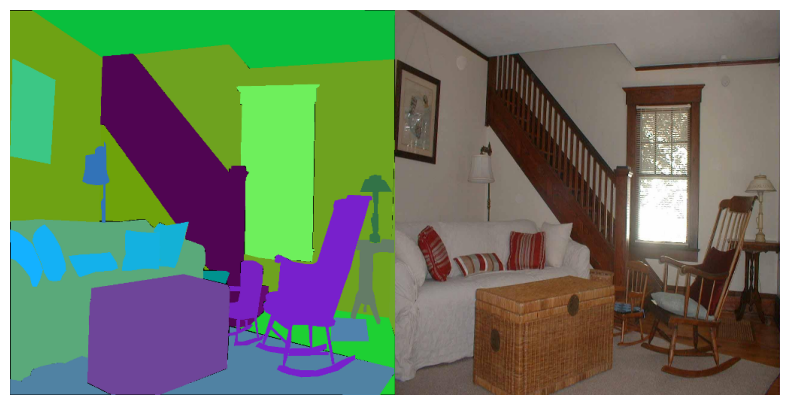

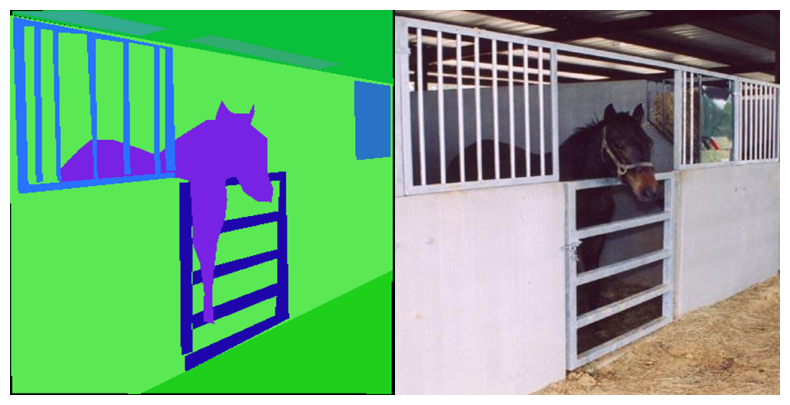

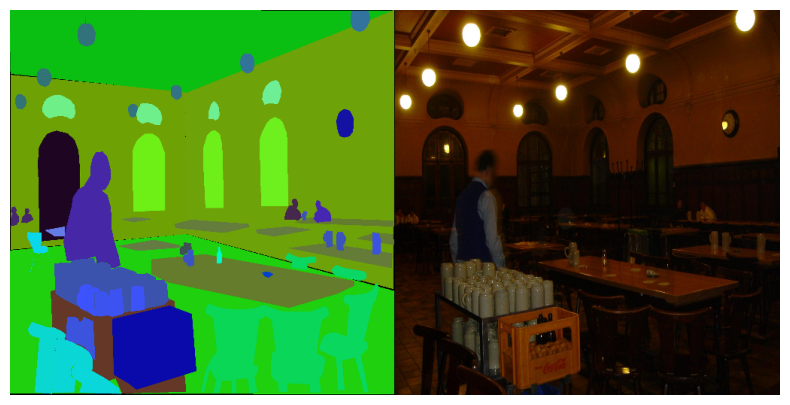

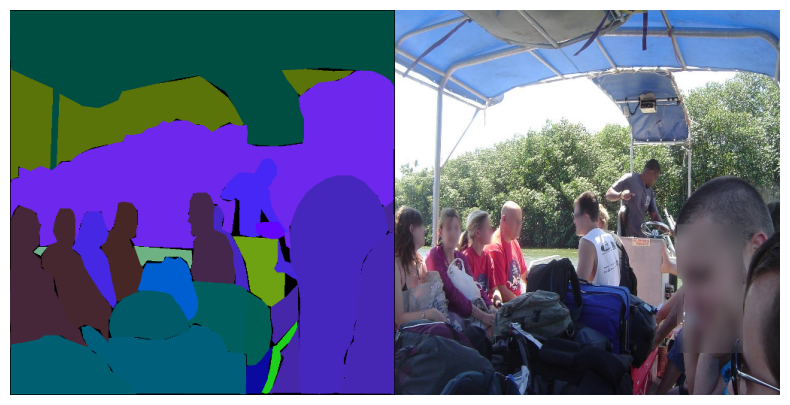

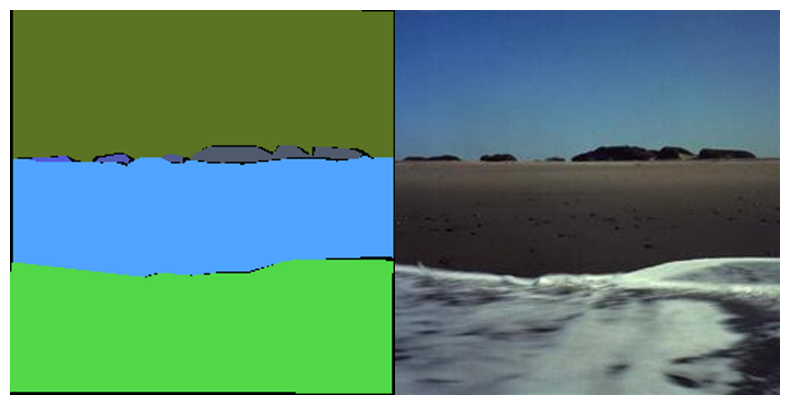

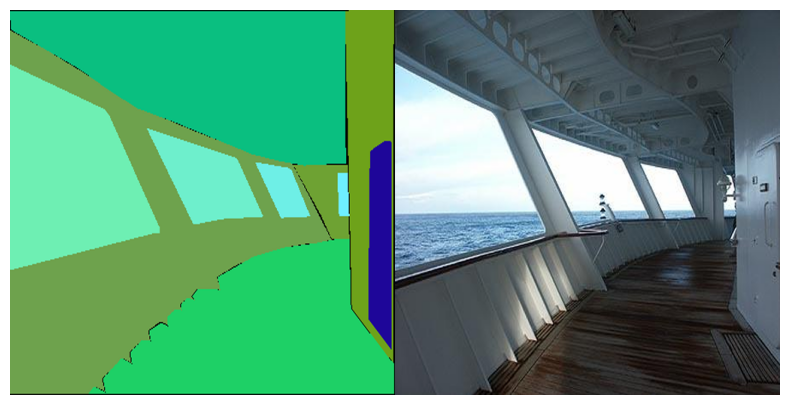

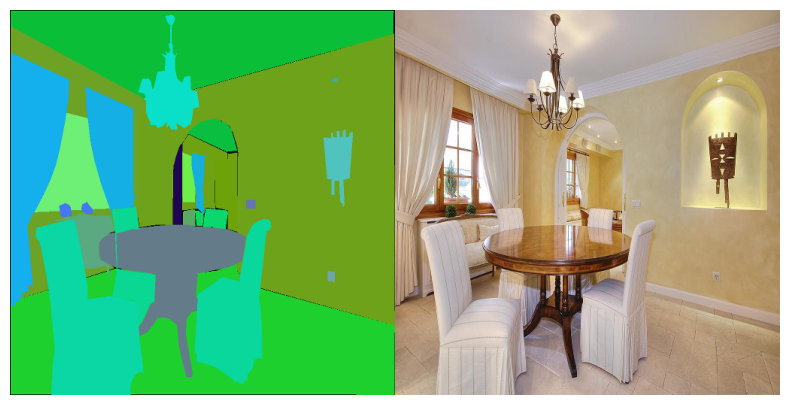

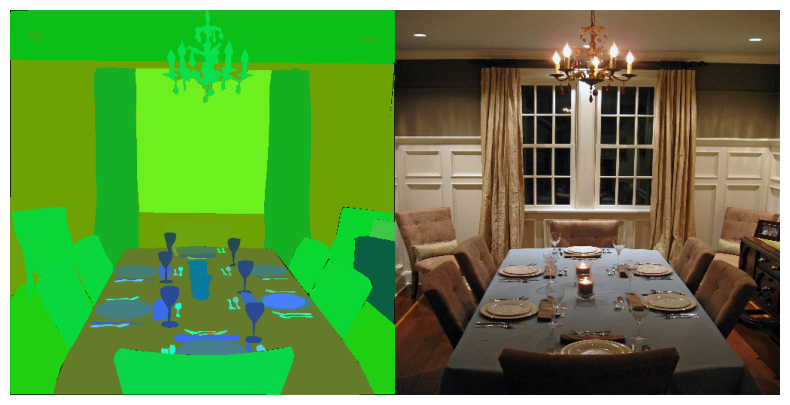

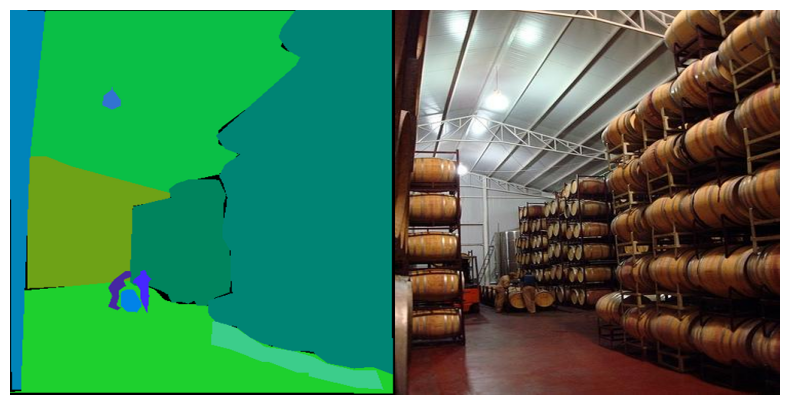

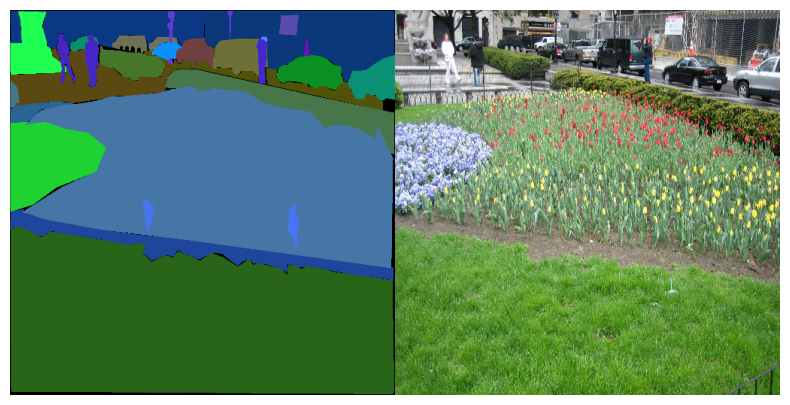

In [3]:
for _ in range(10):
    idx = randint(0, len(dataset) - 1)
    data = dataset[idx]
    source = data['hint'] * 255
    source = source.astype(np.int32)
    source = source[..., ::-1]
    target = (data['jpg'] + 1) * 127.5
    target = target.astype(np.int32)
    target = target[..., ::-1]
    plt.figure(figsize=(10,5))
    plt.imshow(np.concatenate([source, target], 1))
    plt.axis('off')

In [4]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from cldm.logger import ImageLogger
from cldm.model import create_model, load_state_dict


# Configs
resume_path = './ControlNet/models/control_sd15_ini.ckpt'
batch_size = 2
logger_freq = 300
learning_rate = 1e-5
sd_locked = True
only_mid_control = False


# First use cpu to load models. Pytorch Lightning will automatically move it to GPUs.
model = create_model('./ControlNet/models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(resume_path, location='cpu'))
model.learning_rate = learning_rate
model.sd_locked = sd_locked
model.only_mid_control = only_mid_control


# Misc
dataloader = DataLoader(dataset, num_workers=0, batch_size=batch_size, shuffle=True)
logger = ImageLogger(batch_frequency=logger_freq)
trainer = pl.Trainer(
    precision=32, 
    callbacks=[logger],
    accumulate_grad_batches=2,
    max_epochs=20,
    check_val_every_n_epoch=1, 
    default_root_dir='/home/jacob/work/ControlNet',
    logger=True,
)


# Train!
trainer.fit(model, dataloader)


No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.4.layer_norm2.weight', 'vision_model.encoder.layers.23.mlp.fc1.weight', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.20.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.mlp.fc1.weight', 'vision_model.encoder.layers.20.layer_norm2.bias', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.mlp.fc2.bias', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.self_attn.out_proj.weight', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.18.self_attn.out_proj.bias', 'vision_model.encoder.layers.18.self_a

Loaded model config from [./ControlNet/models/cldm_v15.yaml]
Loaded state_dict from [./ControlNet/models/control_sd15_ini.ckpt]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jacob/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type               | Params
---------------------------------------------------------
0 | model             | DiffusionWrapper   | 859 M 
1 | first_stage_model | AutoencoderKL      | 83.7 M
2 

Training: 0it [00:00, ?it/s]

/home/jacob/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/jacob/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('global_step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps
Data shape for DDIM sampling is (2, 4, 6